In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime  
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler
import math

%matplotlib inline
#plot size
plt.rcParams['figure.figsize'] = (20,10)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_path = Path().resolve().parent/'datasets/bike_sharing_hourly/bike_sharing_hourly.csv'
print(dataset_path)

df = pd.read_csv(dataset_path)
df

/home/kh/bike-share-analysis/datasets/bike_sharing_hourly/bike_sharing_hourly.csv


instant      dteday  season  yr  mnth  hr  holiday  weekday  \
0            1  2011-01-01       1   0     1   0        0        6   
1            2  2011-01-01       1   0     1   1        0        6   
2            3  2011-01-01       1   0     1   2        0        6   
3            4  2011-01-01       1   0     1   3        0        6   
4            5  2011-01-01       1   0     1   4        0        6   
...        ...         ...     ...  ..   ...  ..      ...      ...   
17374    17375  2012-12-31       1   1    12  19        0        1   
17375    17376  2012-12-31       1   1    12  20        0        1   
17376    17377  2012-12-31       1   1    12  21        0        1   
17377    17378  2012-12-31       1   1    12  22        0        1   
17378    17379  2012-12-31       1   1    12  23        0        1   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
0               0           1  0.24  0.2879  0.81     0.0000       3   
1               0           1  0.22  0.2727  0.80     0.0000       8   
2               0           1  0.22  0.2727  0.80     0.0000       5   
3               0           1  0.24  0.2879  0.75     0.0000       3   
4               0           1  0.24  0.2879  0.75     0.0000       0   
...           ...         ...   ...     ...   ...        ...     ...   
17374           1           2  0.26  0.2576  0.60     0.1642      11   
17375           1           2  0.26  0.2576  0.60     0.1642       8   
17376           1           1  0.26  0.2576  0.60     0.1642       7   
17377           1           1  0.26  0.2727  0.56     0.1343      13   
17378           1           1  0.26  0.2727  0.65     0.1343      12   

       registered  cnt  
0              13   16  
1              32   40  
2              27   32  
3              10   13  
4               1    1  
...           ...  ...  
17374         108  119  
17375          81   89  
17376          83   90  
17377          48   61  
17378          37   49  

[17379 rows x 17 columns]

In [3]:
#check unique column
df.columns.unique()

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [4]:
df['dteday'] = pd.to_datetime(df['dteday'])
df.dteday.describe()

count                   17379
unique                    731
top       2011-01-01 00:00:00
freq                       24
first     2011-01-01 00:00:00
last      2012-12-31 00:00:00
Name: dteday, dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

In [6]:
#check missing value
df.isnull().values.any()

False

In [7]:
# Check the total number of days for 2 years
unique_day = 731
total_hr_per_day = 24
new_total_instances = unique_day*total_hr_per_day
print(new_total_instances)

17544


In [8]:
hourly_data = pd.date_range('2011-01-01', periods = new_total_instances, freq = 'H')
hourly_data = pd.DataFrame(hourly_data)
hourly_data.columns = ['datetime']
hourly_data

datetime
0     2011-01-01 00:00:00
1     2011-01-01 01:00:00
2     2011-01-01 02:00:00
3     2011-01-01 03:00:00
4     2011-01-01 04:00:00
...                   ...
17539 2012-12-31 19:00:00
17540 2012-12-31 20:00:00
17541 2012-12-31 21:00:00
17542 2012-12-31 22:00:00
17543 2012-12-31 23:00:00

[17544 rows x 1 columns]

In [9]:
# Create new columns for year, month, day and hour for the dataframe
df['year'] = df['dteday'].dt.year
df['month'] = df['dteday'].dt.month
df['day'] = df['dteday'].dt.day
df['hour'] = df['hr']
df['dayofweek'] = df['dteday'].dt.day_name()

df.tail()

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
17374    17375 2012-12-31       1   1    12  19        0        1           1   
17375    17376 2012-12-31       1   1    12  20        0        1           1   
17376    17377 2012-12-31       1   1    12  21        0        1           1   
17377    17378 2012-12-31       1   1    12  22        0        1           1   
17378    17379 2012-12-31       1   1    12  23        0        1           1   

       weathersit  ...   hum  windspeed  casual  registered  cnt  year  month  \
17374           2  ...  0.60     0.1642      11         108  119  2012     12   
17375           2  ...  0.60     0.1642       8          81   89  2012     12   
17376           1  ...  0.60     0.1642       7          83   90  2012     12   
17377           1  ...  0.56     0.1343      13          48   61  2012     12   
17378           1  ...  0.65     0.1343      12          37   49  2012     12   

       day  hour  dayofweek  
17374   31    19     Monday  
17375   31    20     Monday  
17376   31    21     Monday  
17377   31    22     Monday  
17378   31    23     Monday  

[5 rows x 22 columns]

In [10]:
# Concat new dataframe into 'datetime' and remove unnecesarry columns
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day','hour']])
df = df.drop(['instant' ,'dteday', 'yr','mnth','hr', 'weekday'], axis = 1)
df.rename(columns = {'weathersit' : 'weather'}, inplace = True)
df

season  holiday  workingday  weather  temp   atemp   hum  windspeed  \
0           1        0           0        1  0.24  0.2879  0.81     0.0000   
1           1        0           0        1  0.22  0.2727  0.80     0.0000   
2           1        0           0        1  0.22  0.2727  0.80     0.0000   
3           1        0           0        1  0.24  0.2879  0.75     0.0000   
4           1        0           0        1  0.24  0.2879  0.75     0.0000   
...       ...      ...         ...      ...   ...     ...   ...        ...   
17374       1        0           1        2  0.26  0.2576  0.60     0.1642   
17375       1        0           1        2  0.26  0.2576  0.60     0.1642   
17376       1        0           1        1  0.26  0.2576  0.60     0.1642   
17377       1        0           1        1  0.26  0.2727  0.56     0.1343   
17378       1        0           1        1  0.26  0.2727  0.65     0.1343   

       casual  registered  cnt  year  month  day  hour dayofweek  \
0           3          13   16  2011      1    1     0  Saturday   
1           8          32   40  2011      1    1     1  Saturday   
2           5          27   32  2011      1    1     2  Saturday   
3           3          10   13  2011      1    1     3  Saturday   
4           0           1    1  2011      1    1     4  Saturday   
...       ...         ...  ...   ...    ...  ...   ...       ...   
17374      11         108  119  2012     12   31    19    Monday   
17375       8          81   89  2012     12   31    20    Monday   
17376       7          83   90  2012     12   31    21    Monday   
17377      13          48   61  2012     12   31    22    Monday   
17378      12          37   49  2012     12   31    23    Monday   

                 datetime  
0     2011-01-01 00:00:00  
1     2011-01-01 01:00:00  
2     2011-01-01 02:00:00  
3     2011-01-01 03:00:00  
4     2011-01-01 04:00:00  
...                   ...  
17374 2012-12-31 19:00:00  
17375 2012-12-31 20:00:00  
17376 2012-12-31 21:00:00  
17377 2012-12-31 22:00:00  
17378 2012-12-31 23:00:00  

[17379 rows x 17 columns]

In [11]:
df.describe().T

count         mean         std      min        25%        50%  \
season      17379.0     2.501640    1.106918     1.00     2.0000     3.0000   
holiday     17379.0     0.028770    0.167165     0.00     0.0000     0.0000   
workingday  17379.0     0.682721    0.465431     0.00     0.0000     1.0000   
weather     17379.0     1.425283    0.639357     1.00     1.0000     1.0000   
temp        17379.0     0.496987    0.192556     0.02     0.3400     0.5000   
atemp       17379.0     0.475775    0.171850     0.00     0.3333     0.4848   
hum         17379.0     0.627229    0.192930     0.00     0.4800     0.6300   
windspeed   17379.0     0.190098    0.122340     0.00     0.1045     0.1940   
casual      17379.0    35.676218   49.305030     0.00     4.0000    17.0000   
registered  17379.0   153.786869  151.357286     0.00    34.0000   115.0000   
cnt         17379.0   189.463088  181.387599     1.00    40.0000   142.0000   
year        17379.0  2011.502561    0.500008  2011.00  2011.0000  2012.0000   
month       17379.0     6.537775    3.438776     1.00     4.0000     7.0000   
day         17379.0    15.683411    8.789373     1.00     8.0000    16.0000   
hour        17379.0    11.546752    6.914405     0.00     6.0000    12.0000   

                  75%        max  
season         3.0000     4.0000  
holiday        0.0000     1.0000  
workingday     1.0000     1.0000  
weather        2.0000     4.0000  
temp           0.6600     1.0000  
atemp          0.6212     1.0000  
hum            0.7800     1.0000  
windspeed      0.2537     0.8507  
casual        48.0000   367.0000  
registered   220.0000   886.0000  
cnt          281.0000   977.0000  
year        2012.0000  2012.0000  
month         10.0000    12.0000  
day           23.0000    31.0000  
hour          18.0000    23.0000

EDA and feature engineering

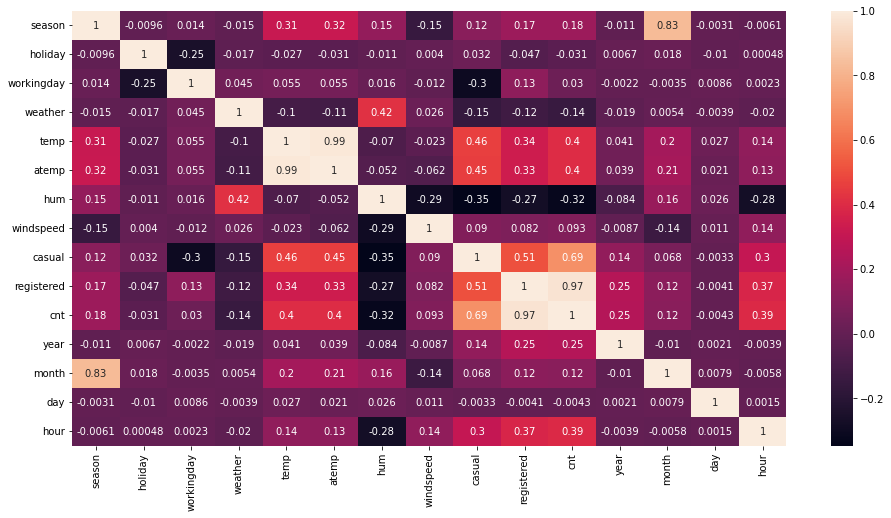

In [12]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

<Figure size 1152x576 with 0 Axes>

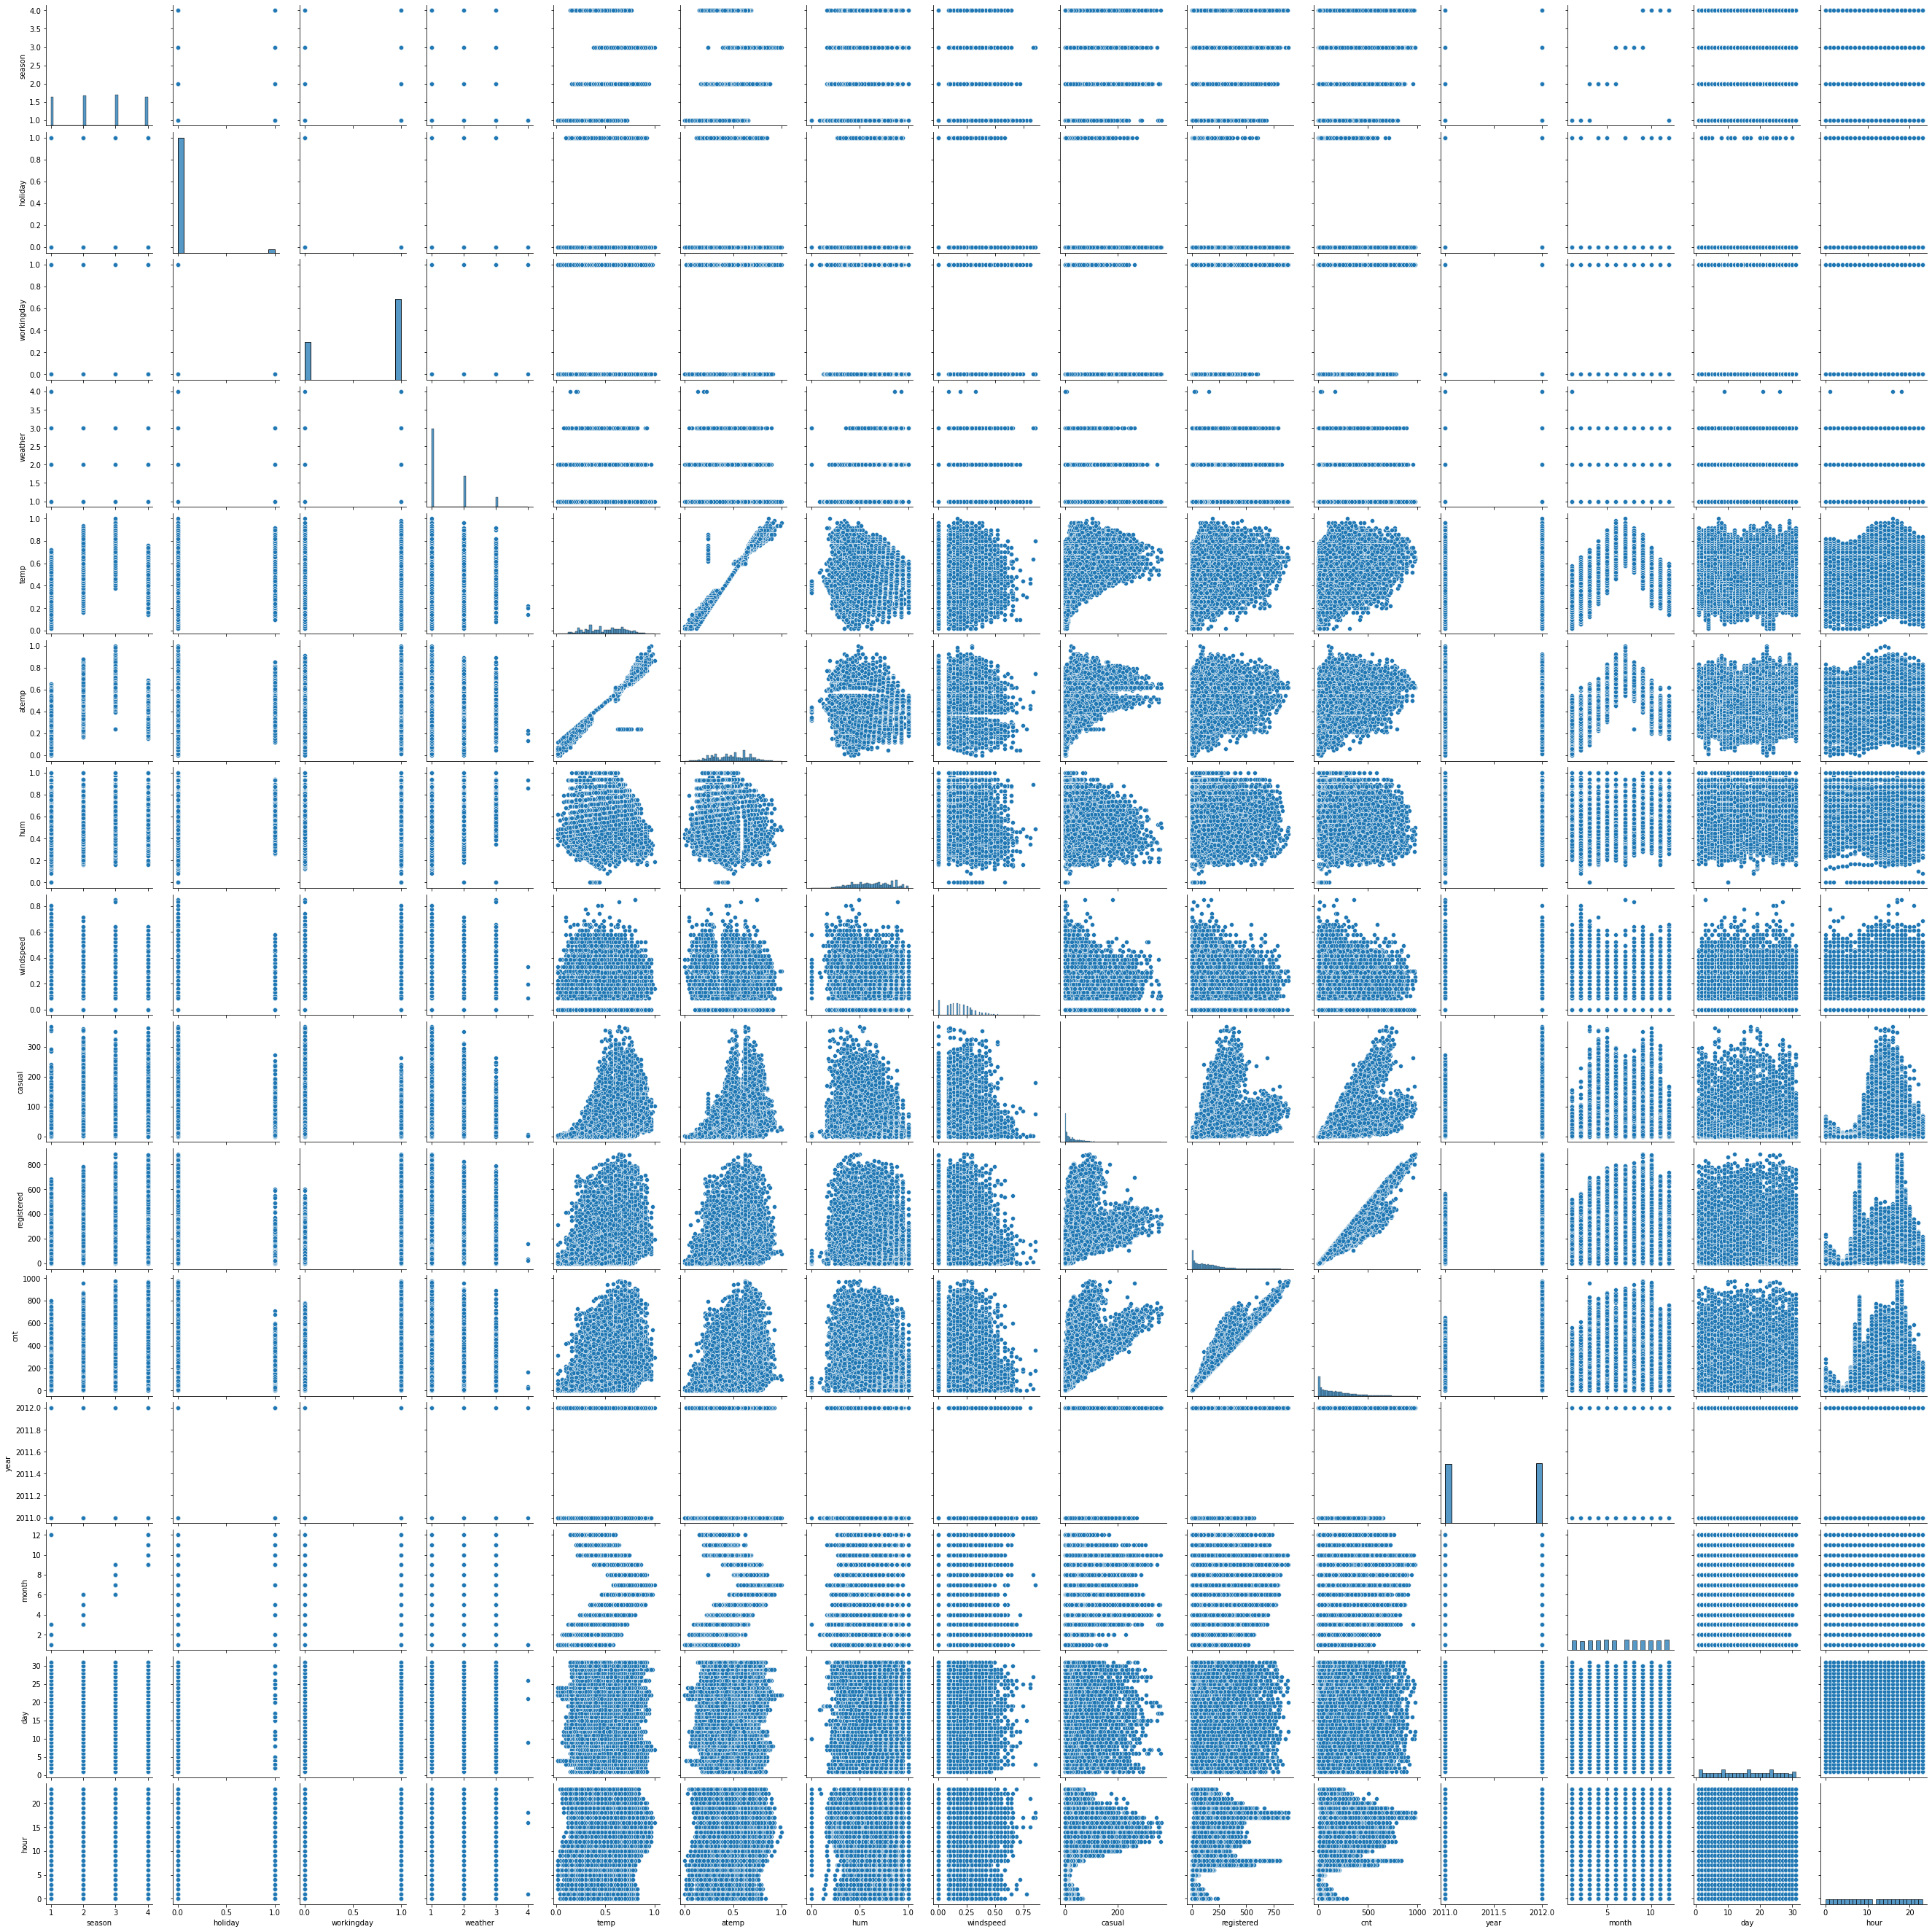

In [13]:
plt.figure(figsize=(16,8))
sns.pairplot(df)
plt.show()

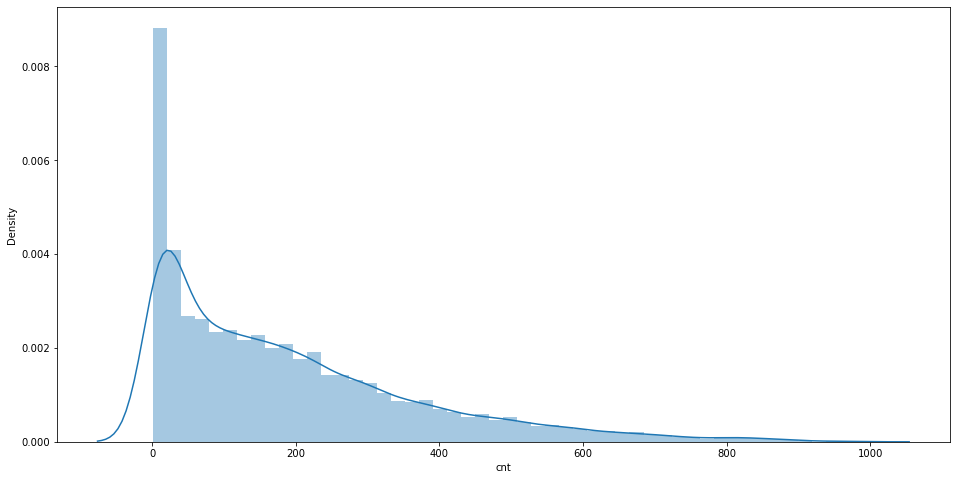

In [14]:
plt.figure(figsize=(16,8))
sns.distplot(df['cnt'])
plt.show()

In [15]:
def scatter_plot():
    for i in df.columns:
        plt.scatter(df[i],df['cnt'])
        plt.title(f"Scatter plot for {i}")
        plt.show()

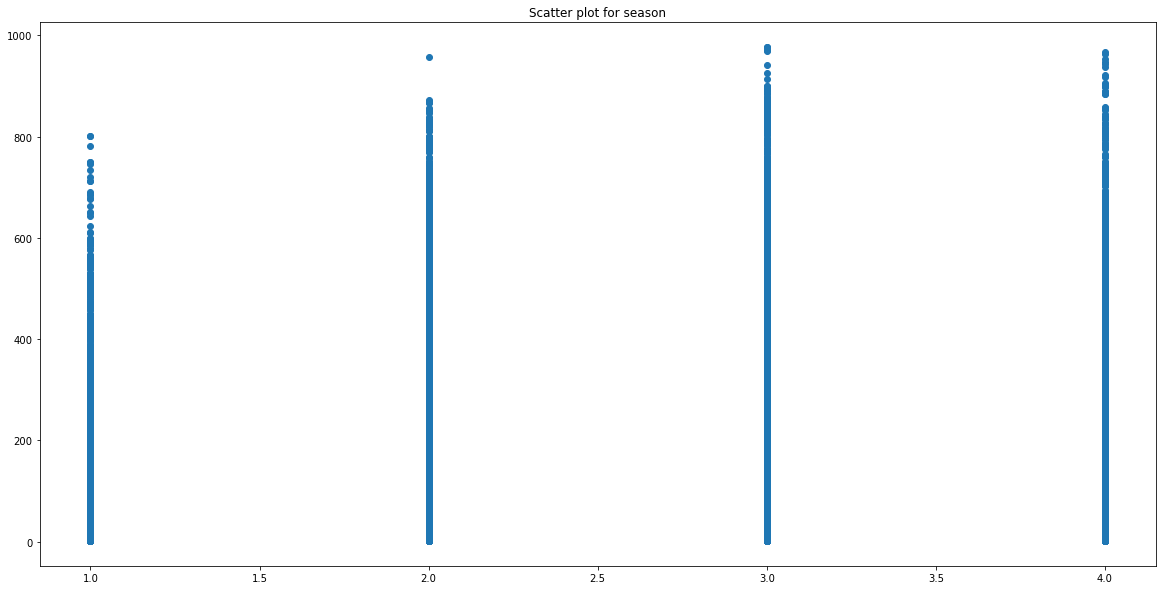

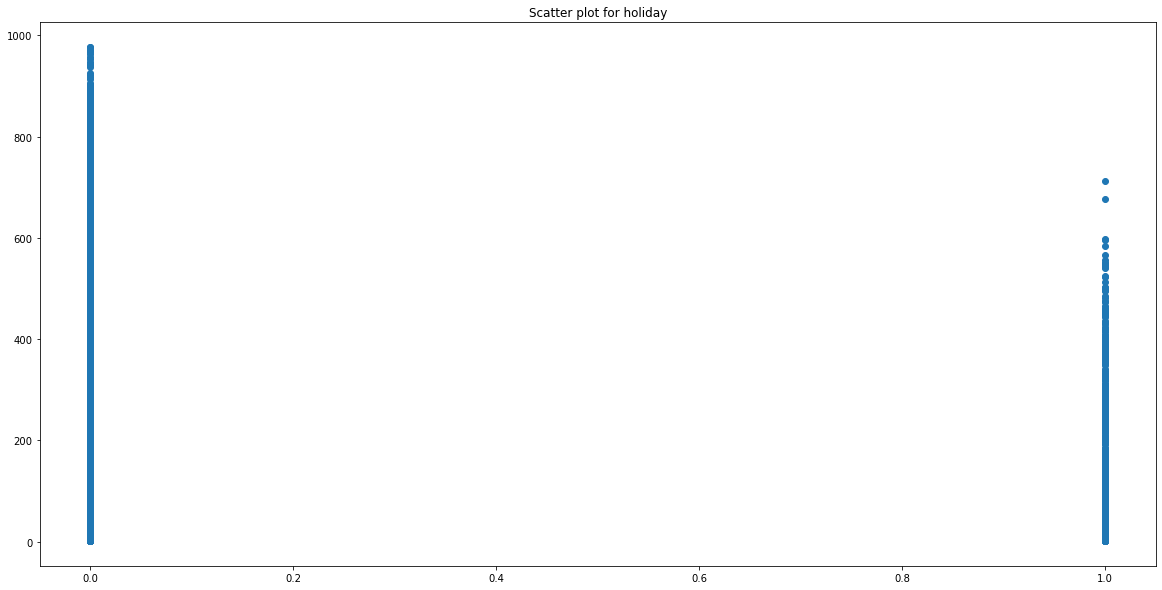

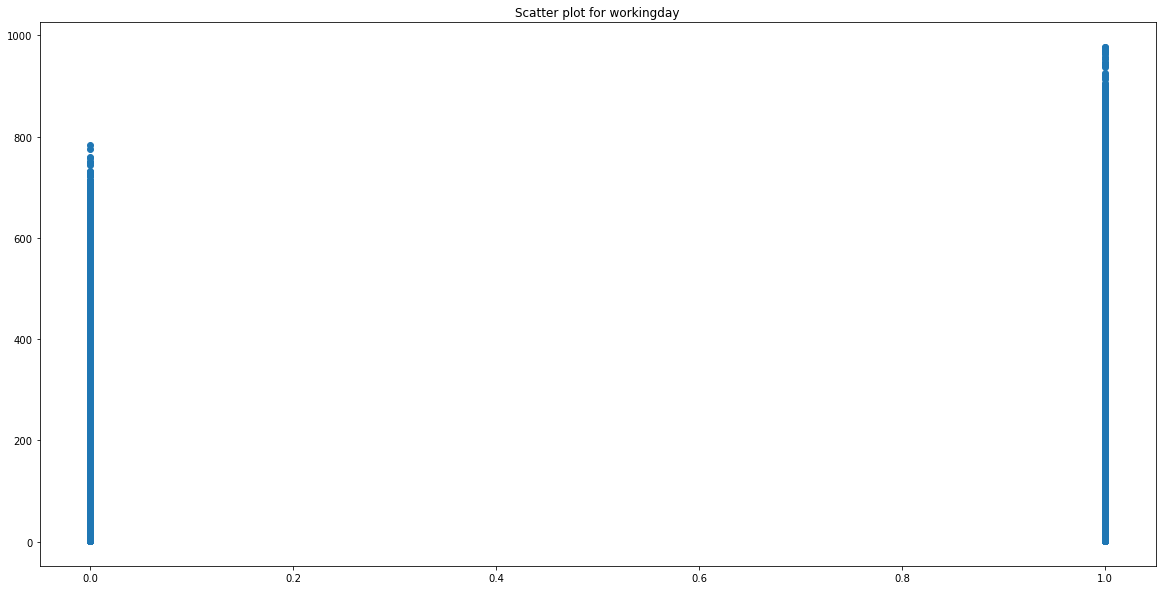

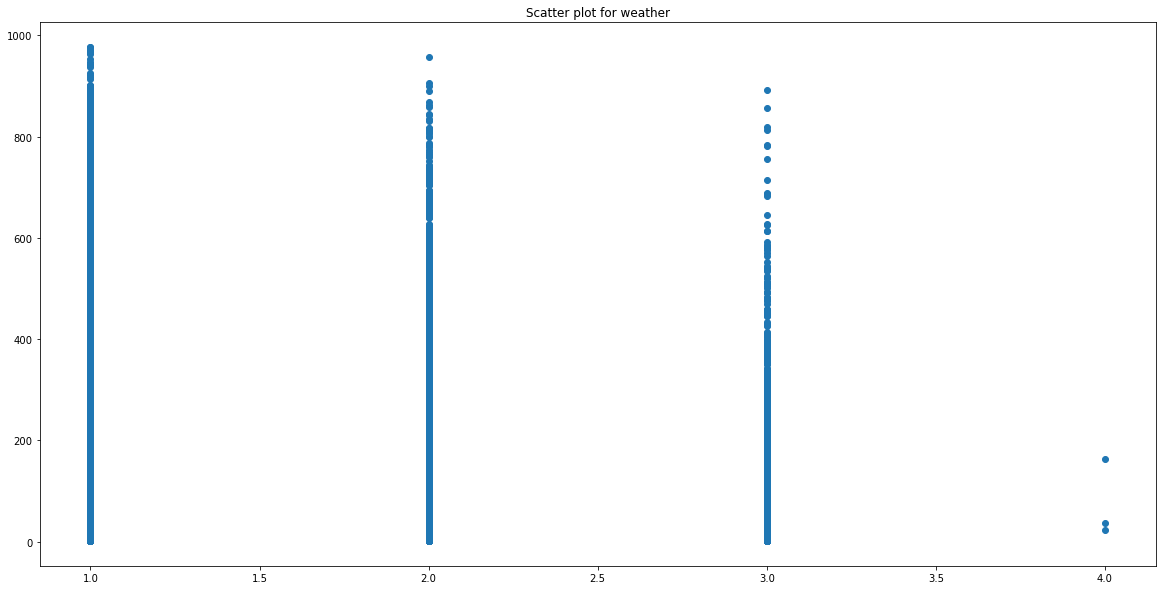

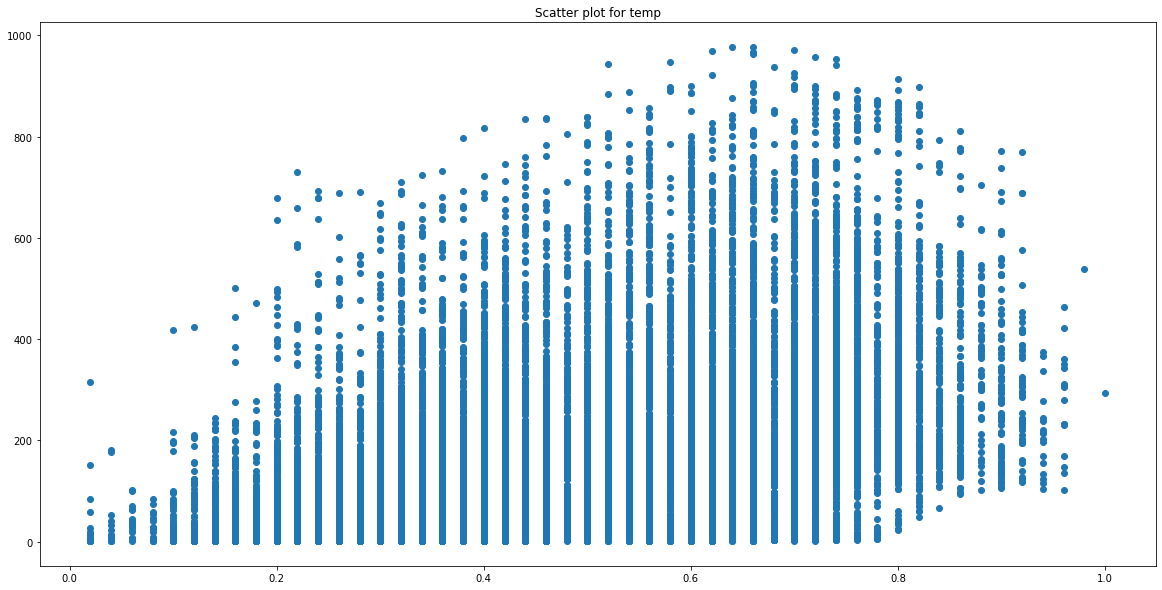

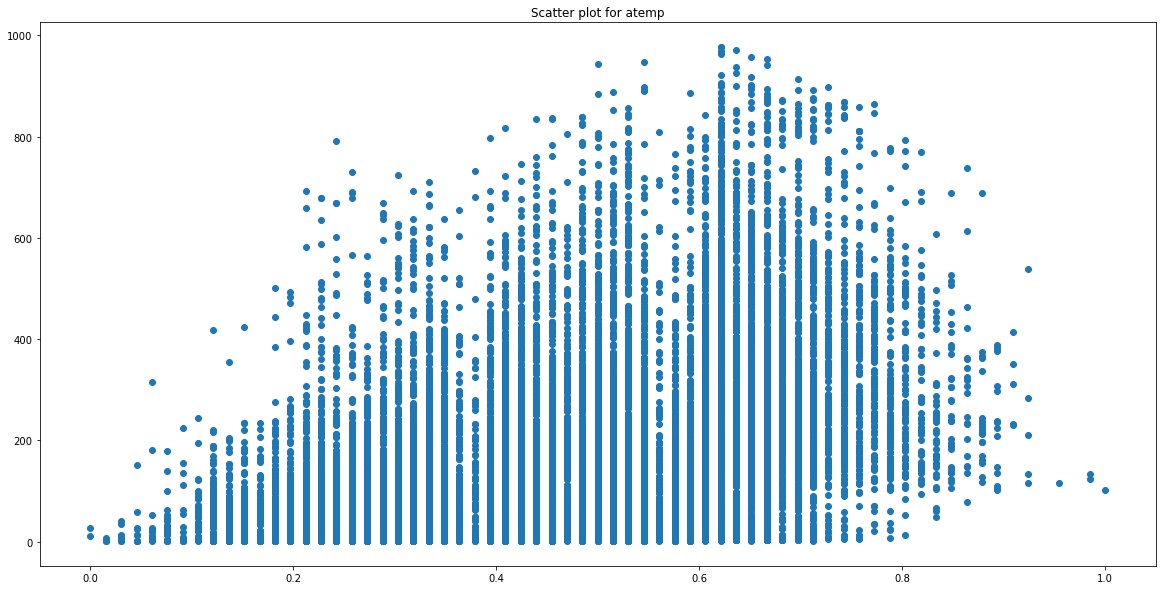

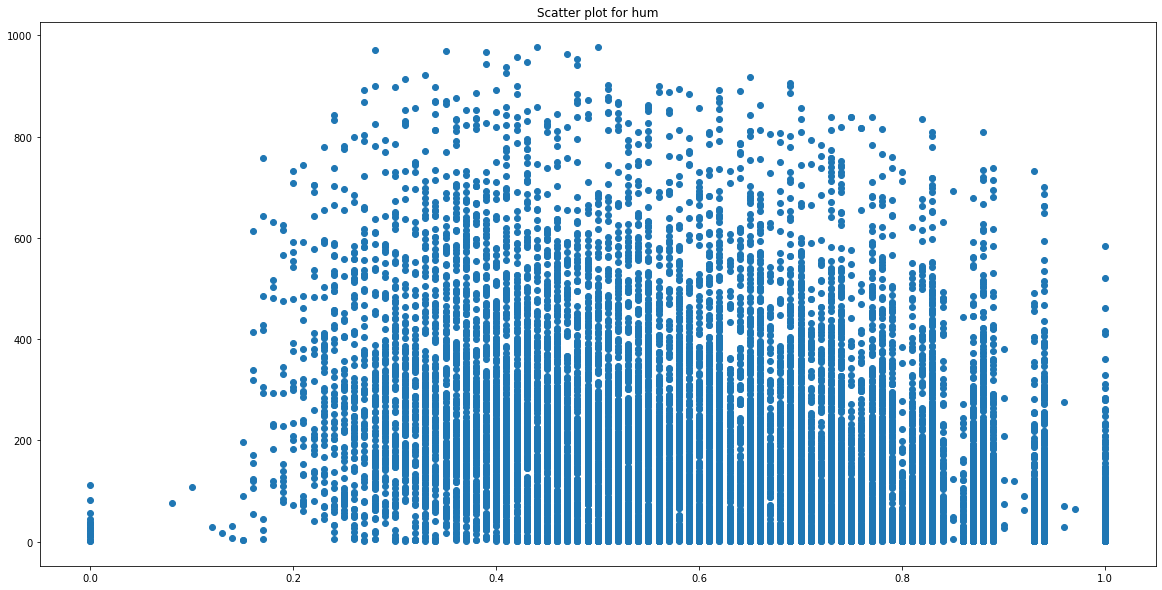

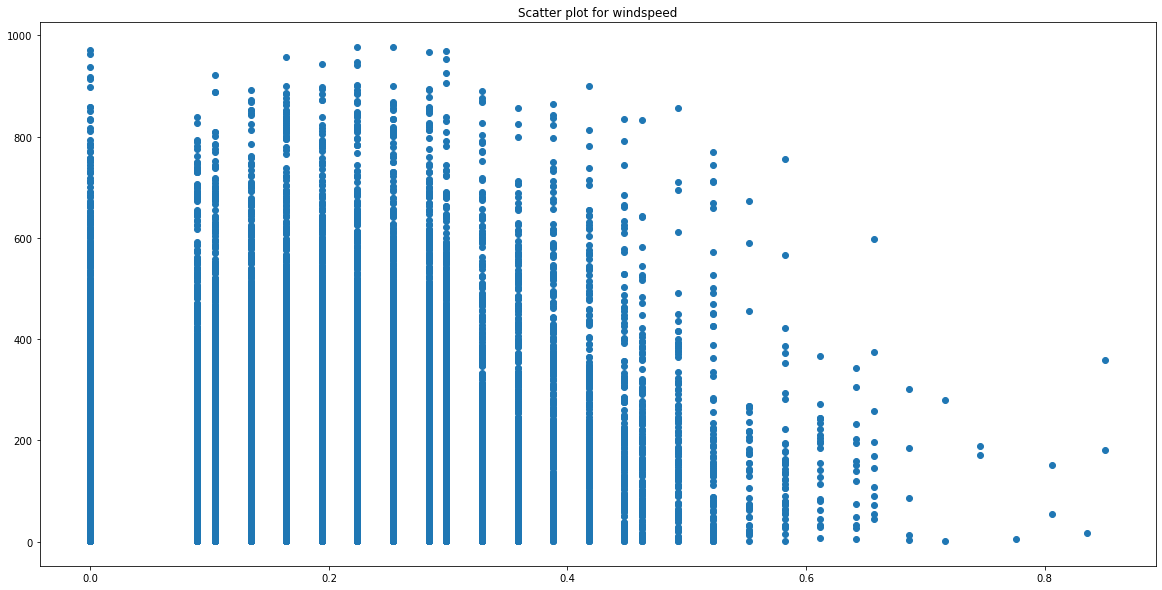

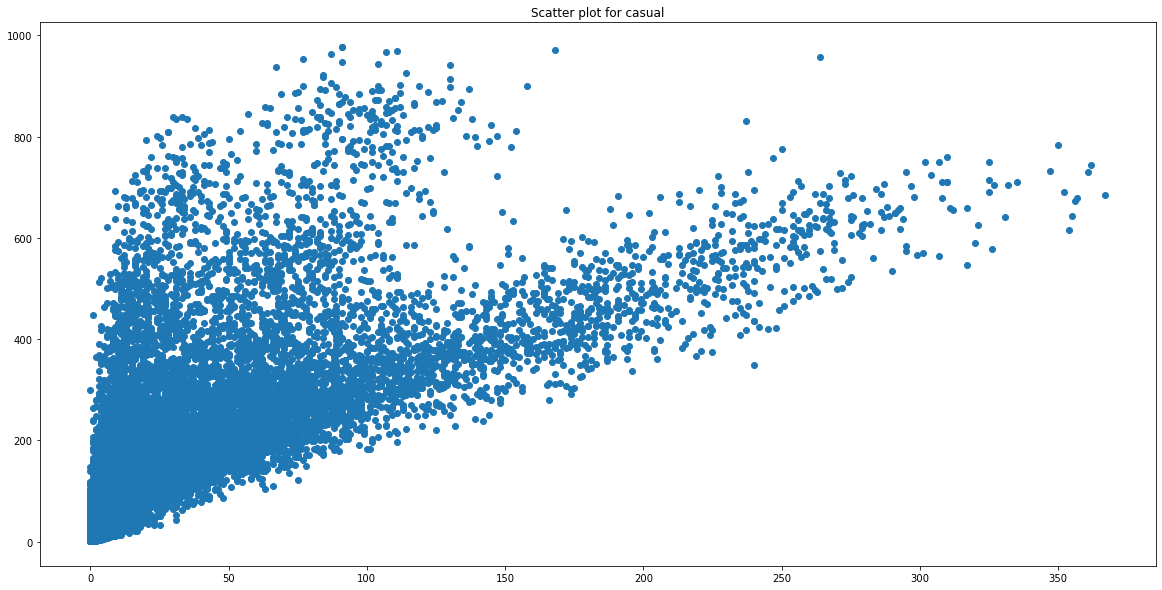

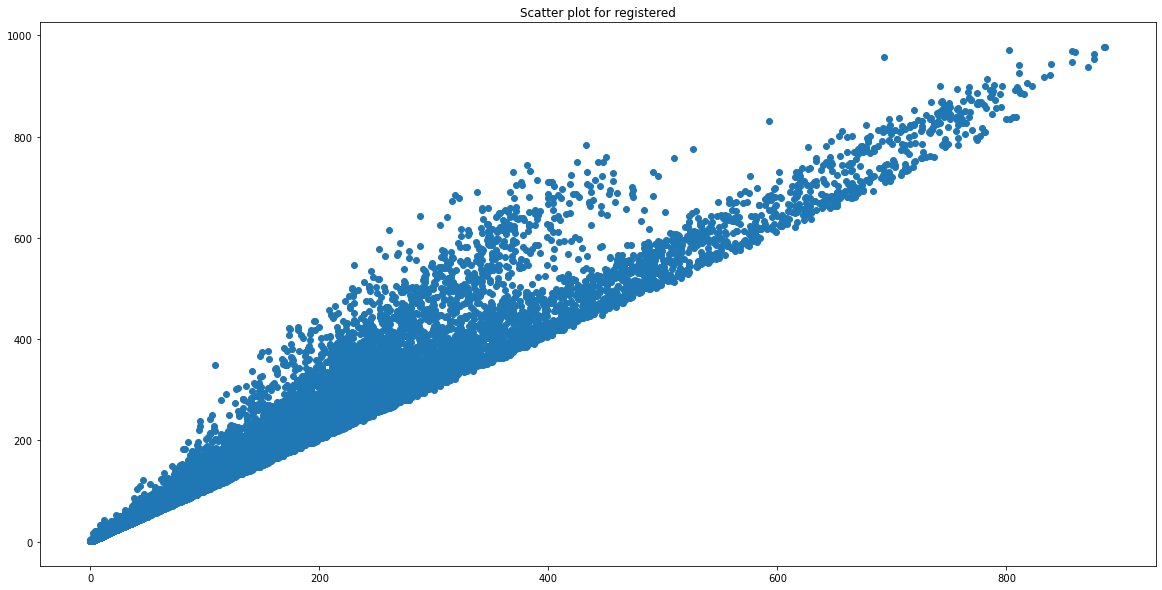

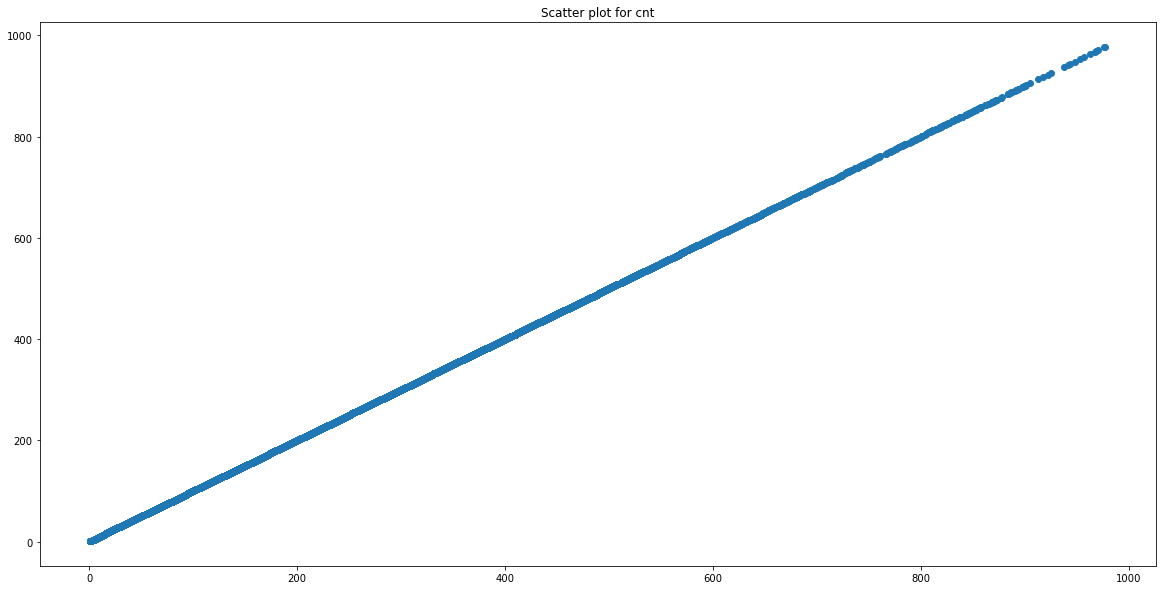

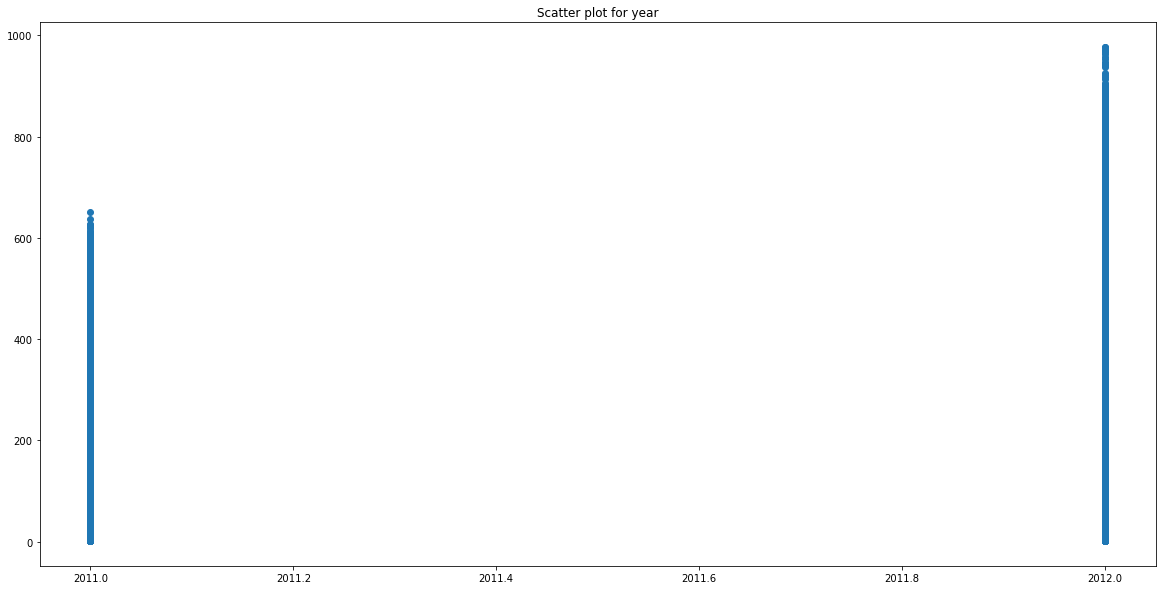

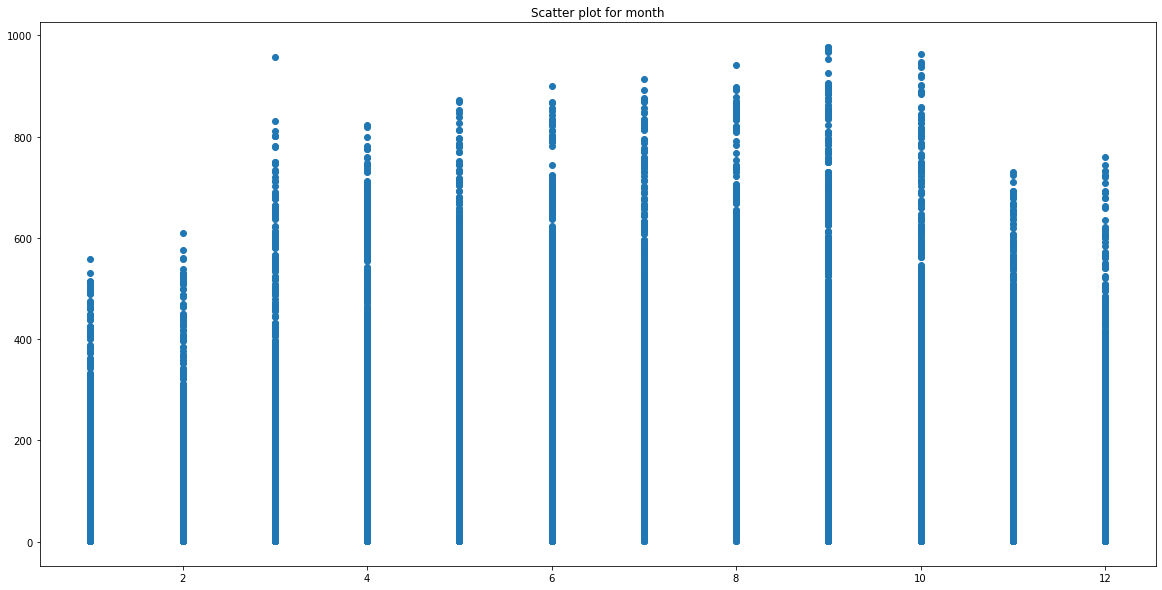

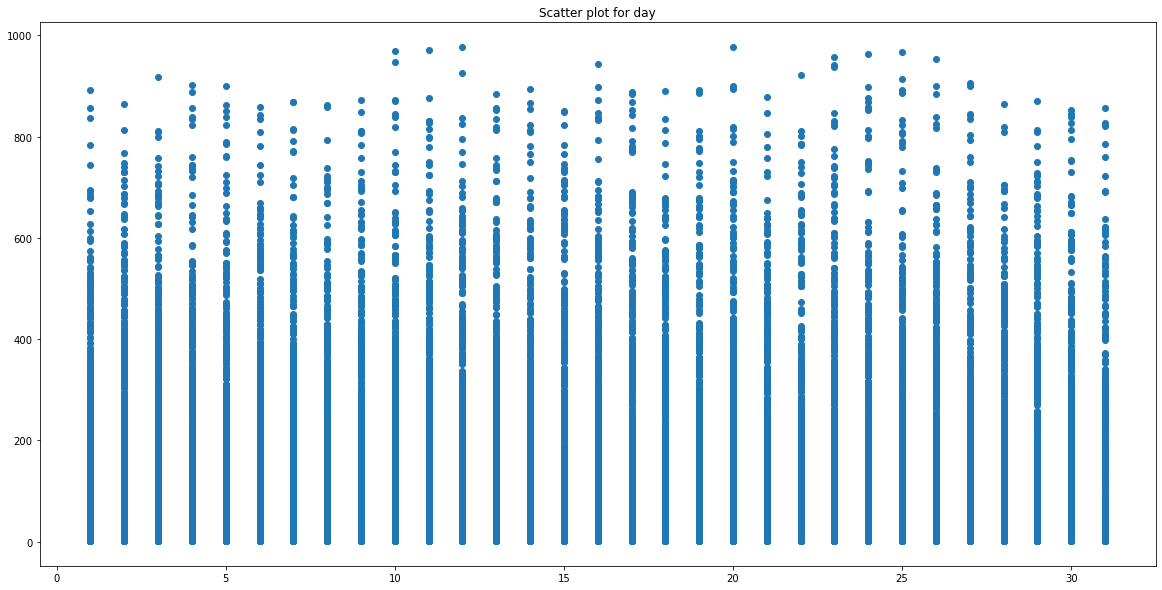

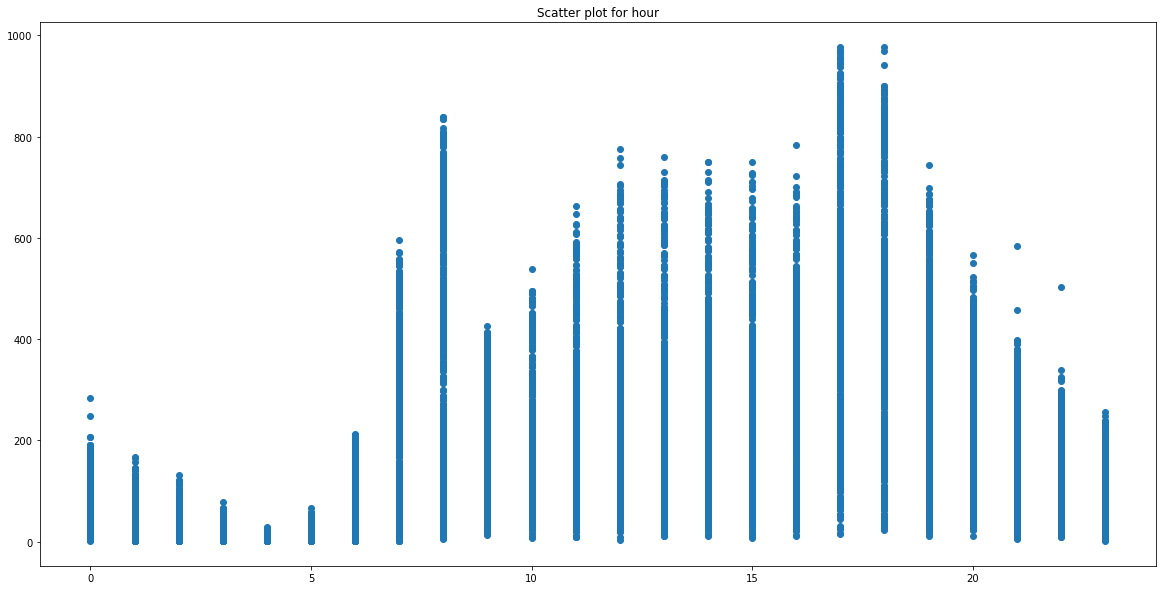

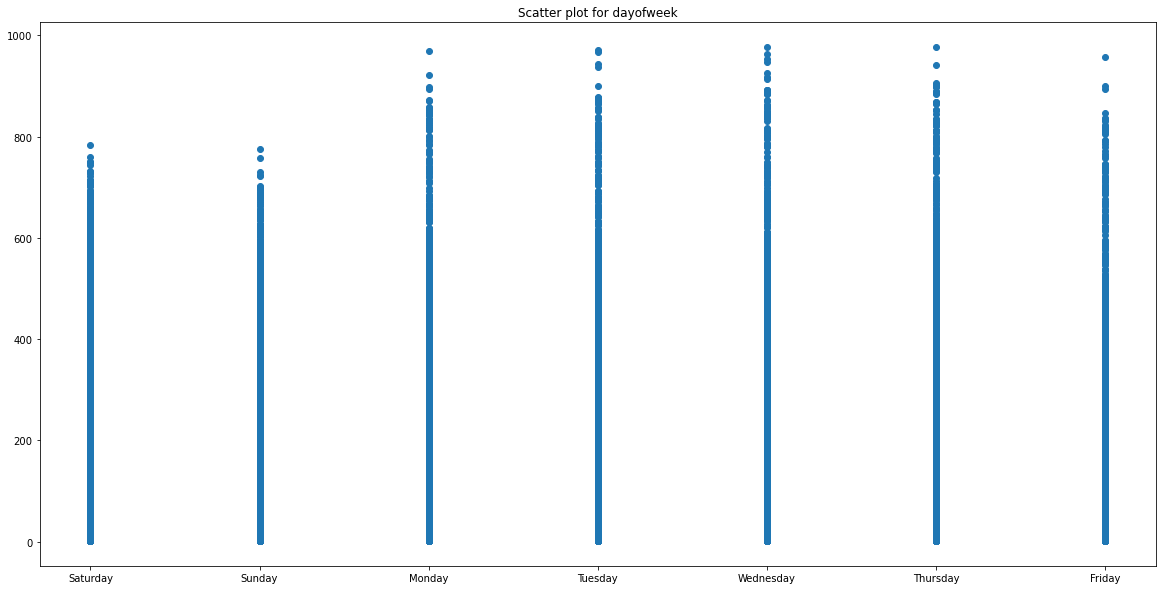

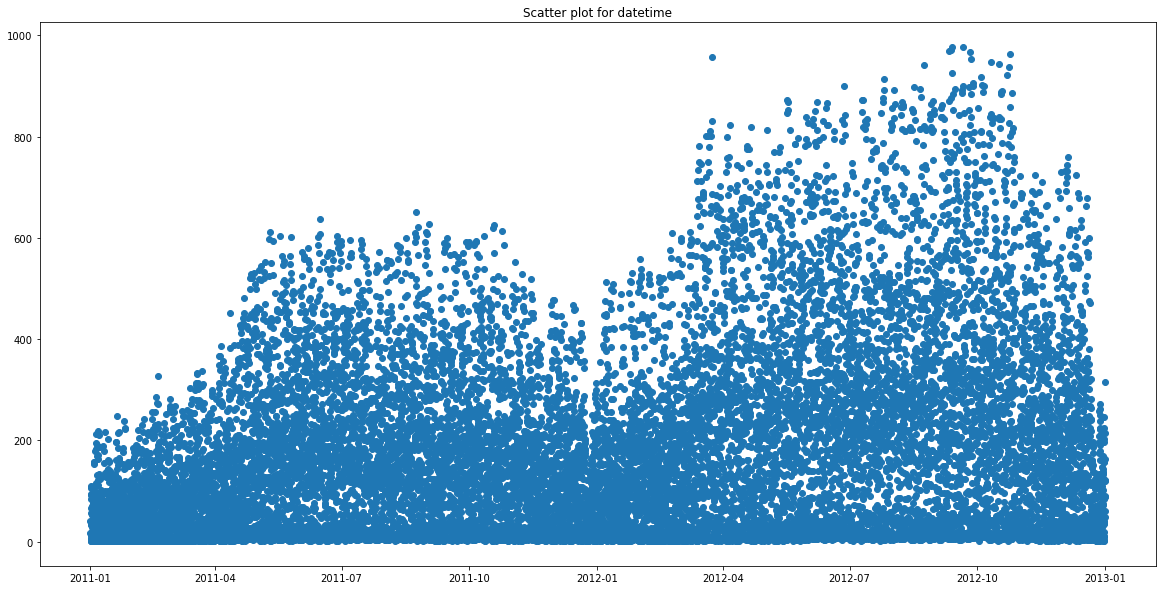

In [16]:
scatter_plot()

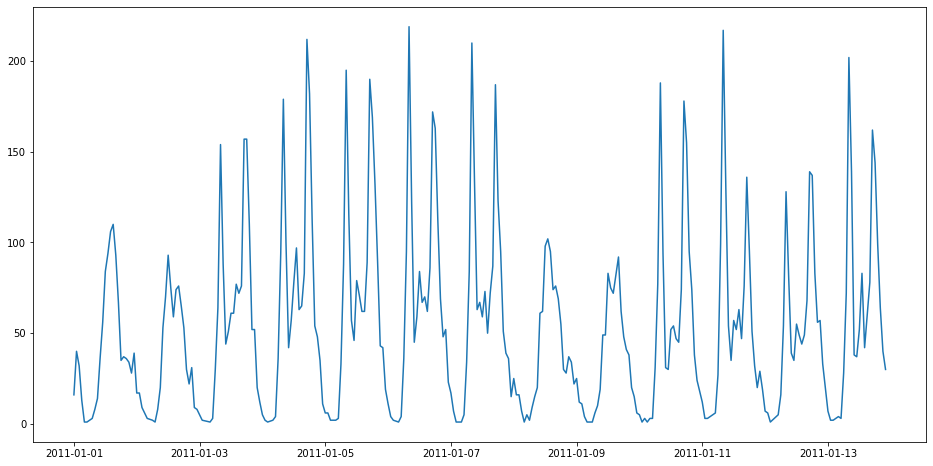

In [17]:
plt.figure(figsize=(16,8))
plt.plot(df.set_index('datetime')["cnt"][0:300])
plt.show()

<AxesSubplot:xlabel='dayofweek', ylabel='cnt'>

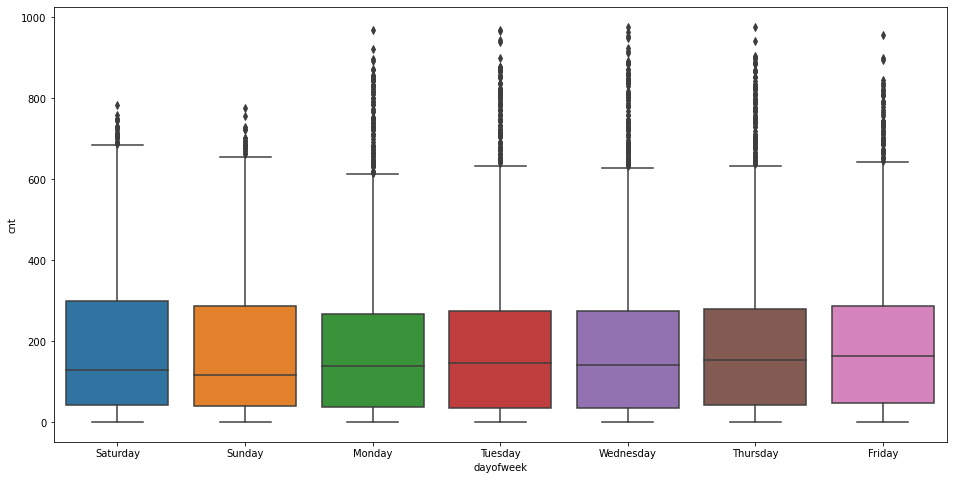

In [18]:
plt.figure(figsize=(16,8))
sns.boxplot(x='dayofweek',y='cnt', data=df)

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['dayofweek'] = le.fit_transform(df['dayofweek'])

<AxesSubplot:xlabel='season', ylabel='cnt'>

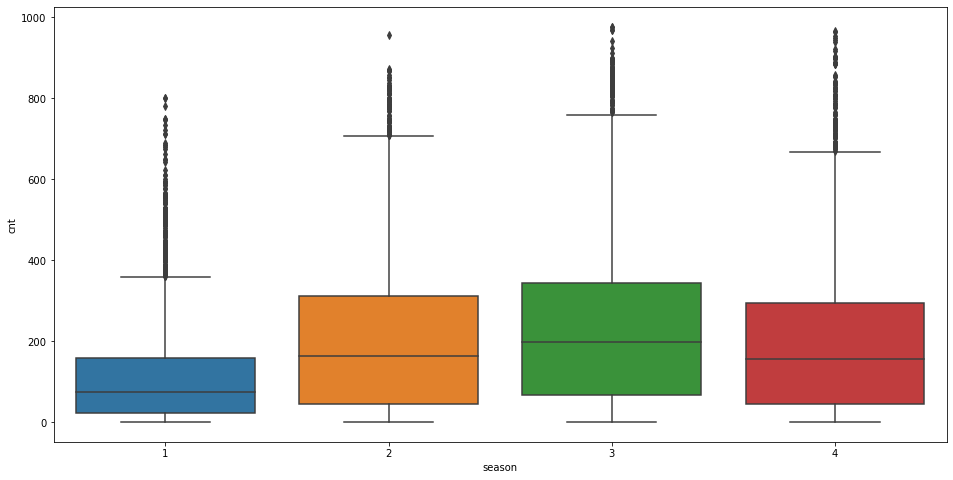

In [20]:
plt.figure(figsize=(16,8))
sns.boxplot(x='season', y='cnt', data=df)

More people rent bicycle on 'Summer' and 'Fall' seasons

<AxesSubplot:xlabel='hour', ylabel='cnt'>

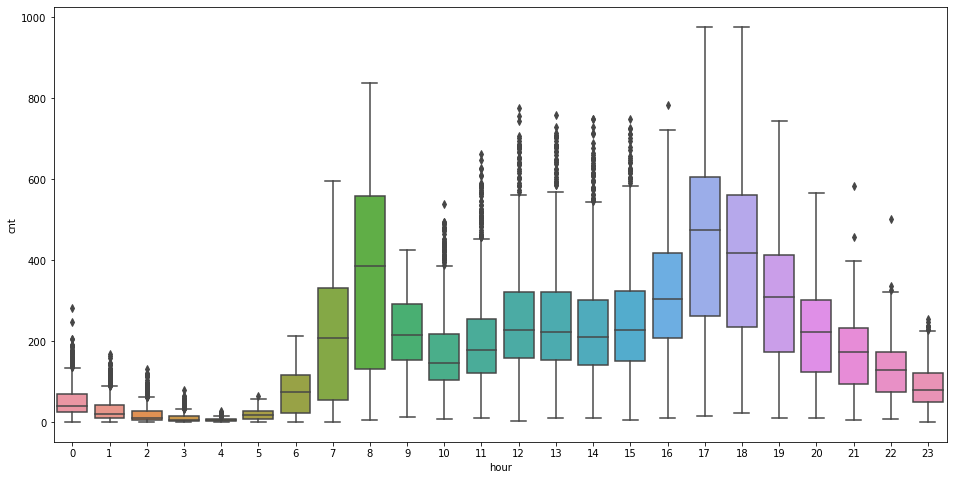

In [21]:
plt.figure(figsize=(16,8))
sns.boxplot(x='hour',y='cnt', data=df) # as we can see there is difference for each hour. We need to use it !

More people prefer on morning 7am-8am and evening 5pm-7pm

<AxesSubplot:xlabel='year', ylabel='cnt'>

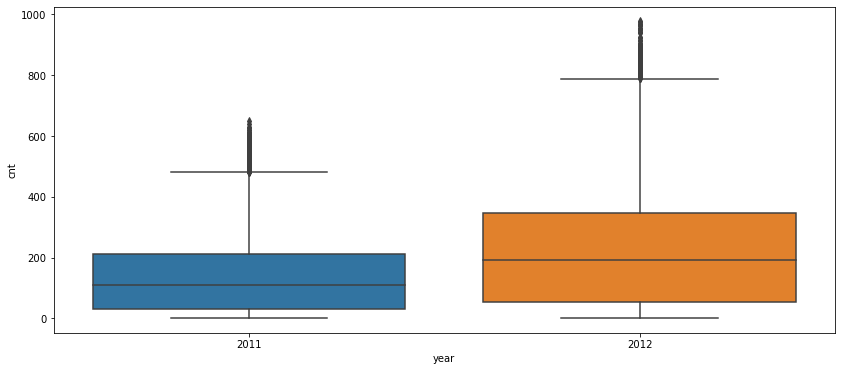

In [22]:
plt.figure(figsize=(14,6))
sns.boxplot(x='year',y='cnt', data=df) # bike were rented in 2012!

(array([2916., 1530., 1505.,  980.,  606.,  500.,  333.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <BarContainer object of 10 artists>)

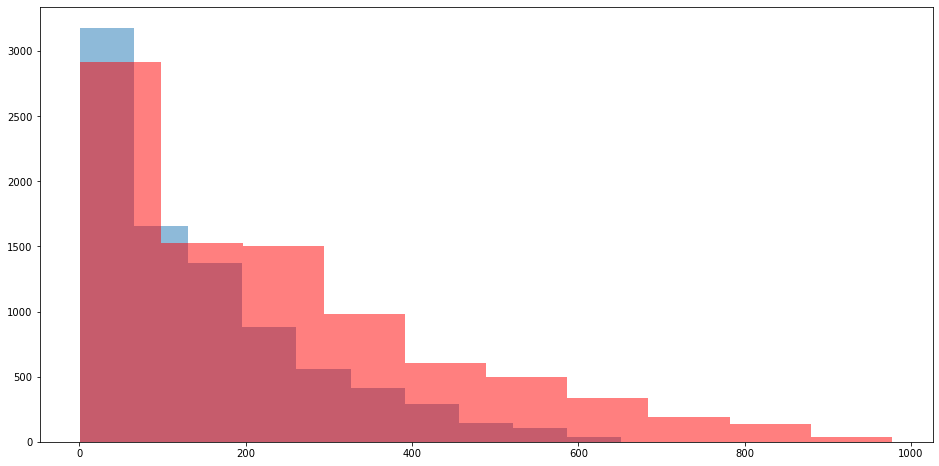

In [23]:
plt.figure(figsize=(16,8))
plt.hist(df['cnt'][df['year'] == 2011], alpha=0.5, label='2011')
plt.hist(df['cnt'][df['year'] == 2012], alpha=0.5, label='2012', color='red')

checking outlier

In [24]:
df.head()

season  holiday  workingday  weather  temp   atemp   hum  windspeed  \
0       1        0           0        1  0.24  0.2879  0.81        0.0   
1       1        0           0        1  0.22  0.2727  0.80        0.0   
2       1        0           0        1  0.22  0.2727  0.80        0.0   
3       1        0           0        1  0.24  0.2879  0.75        0.0   
4       1        0           0        1  0.24  0.2879  0.75        0.0   

   casual  registered  cnt  year  month  day  hour  dayofweek  \
0       3          13   16  2011      1    1     0          2   
1       8          32   40  2011      1    1     1          2   
2       5          27   32  2011      1    1     2          2   
3       3          10   13  2011      1    1     3          2   
4       0           1    1  2011      1    1     4          2   

             datetime  
0 2011-01-01 00:00:00  
1 2011-01-01 01:00:00  
2 2011-01-01 02:00:00  
3 2011-01-01 03:00:00  
4 2011-01-01 04:00:00

In [25]:
df.set_index('datetime', inplace=True)
df.index.name = None

In [26]:
df['2011-01-19 23:00:00':]

season  holiday  workingday  weather  temp   atemp   hum  \
2011-01-19 23:00:00       1        0           1        1  0.30  0.2727  0.52   
2011-01-20 00:00:00       1        0           1        1  0.26  0.2273  0.56   
2011-01-20 01:00:00       1        0           1        1  0.26  0.2727  0.56   
2011-01-20 02:00:00       1        0           1        1  0.26  0.2727  0.56   
2011-01-20 03:00:00       1        0           1        1  0.26  0.2576  0.56   
...                     ...      ...         ...      ...   ...     ...   ...   
2012-12-31 19:00:00       1        0           1        2  0.26  0.2576  0.60   
2012-12-31 20:00:00       1        0           1        2  0.26  0.2576  0.60   
2012-12-31 21:00:00       1        0           1        1  0.26  0.2576  0.60   
2012-12-31 22:00:00       1        0           1        1  0.26  0.2727  0.56   
2012-12-31 23:00:00       1        0           1        1  0.26  0.2727  0.65   

                     windspeed  casual  registered  cnt  year  month  day  \
2011-01-19 23:00:00     0.4627       1          27   28  2011      1   19   
2011-01-20 00:00:00     0.3881       5           8   13  2011      1   20   
2011-01-20 01:00:00     0.0000       2           3    5  2011      1   20   
2011-01-20 02:00:00     0.0000       0           2    2  2011      1   20   
2011-01-20 03:00:00     0.1642       0           1    1  2011      1   20   
...                        ...     ...         ...  ...   ...    ...  ...   
2012-12-31 19:00:00     0.1642      11         108  119  2012     12   31   
2012-12-31 20:00:00     0.1642       8          81   89  2012     12   31   
2012-12-31 21:00:00     0.1642       7          83   90  2012     12   31   
2012-12-31 22:00:00     0.1343      13          48   61  2012     12   31   
2012-12-31 23:00:00     0.1343      12          37   49  2012     12   31   

                     hour  dayofweek  
2011-01-19 23:00:00    23          6  
2011-01-20 00:00:00     0          4  
2011-01-20 01:00:00     1          4  
2011-01-20 02:00:00     2          4  
2011-01-20 03:00:00     3          4  
...                   ...        ...  
2012-12-31 19:00:00    19          1  
2012-12-31 20:00:00    20          1  
2012-12-31 21:00:00    21          1  
2012-12-31 22:00:00    22          1  
2012-12-31 23:00:00    23          1  

[16949 rows x 16 columns]

In [27]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

season          1.0000
holiday         0.0000
workingday      1.0000
weather         1.0000
temp            0.3200
atemp           0.2879
hum             0.3000
windspeed       0.1492
casual         44.0000
registered    186.0000
cnt           241.0000
year            1.0000
month           6.0000
day            15.0000
hour           12.0000
dayofweek       4.0000
dtype: float64


In [28]:
df_without_outliers =df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [29]:
df_without_outliers.dropna(inplace=True)

check difference between original df and without outlier df

In [30]:
print(df.info())
print('*********************************************************************************')
print(df_without_outliers.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   holiday     17379 non-null  int64  
 2   workingday  17379 non-null  int64  
 3   weather     17379 non-null  int64  
 4   temp        17379 non-null  float64
 5   atemp       17379 non-null  float64
 6   hum         17379 non-null  float64
 7   windspeed   17379 non-null  float64
 8   casual      17379 non-null  int64  
 9   registered  17379 non-null  int64  
 10  cnt         17379 non-null  int64  
 11  year        17379 non-null  int64  
 12  month       17379 non-null  int64  
 13  day         17379 non-null  int64  
 14  hour        17379 non-null  int64  
 15  dayofweek   17379 non-null  int64  
dtypes: float64(4), int64(12)
memory usage: 2.8 MB
None
**************************************************************

choose the removed outlier df

In [31]:
df_without_outliers.head()

season  holiday  workingday  weather  temp   atemp   hum  \
2011-01-01 00:00:00       1        0           0        1  0.24  0.2879  0.81   
2011-01-01 01:00:00       1        0           0        1  0.22  0.2727  0.80   
2011-01-01 02:00:00       1        0           0        1  0.22  0.2727  0.80   
2011-01-01 03:00:00       1        0           0        1  0.24  0.2879  0.75   
2011-01-01 04:00:00       1        0           0        1  0.24  0.2879  0.75   

                     windspeed  casual  registered  cnt  year  month  day  \
2011-01-01 00:00:00        0.0       3          13   16  2011      1    1   
2011-01-01 01:00:00        0.0       8          32   40  2011      1    1   
2011-01-01 02:00:00        0.0       5          27   32  2011      1    1   
2011-01-01 03:00:00        0.0       3          10   13  2011      1    1   
2011-01-01 04:00:00        0.0       0           1    1  2011      1    1   

                     hour  dayofweek  
2011-01-01 00:00:00     0          2  
2011-01-01 01:00:00     1          2  
2011-01-01 02:00:00     2          2  
2011-01-01 03:00:00     3          2  
2011-01-01 04:00:00     4          2

Perform imputation on wind speed that equal to 0

<AxesSubplot:xlabel='season', ylabel='windspeed'>

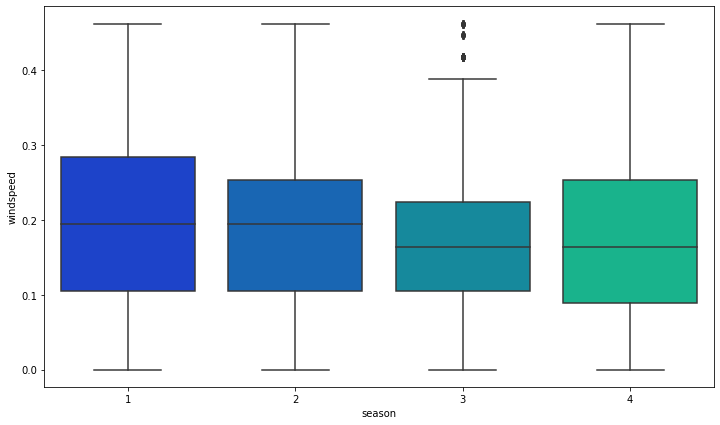

In [32]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='season',y='windspeed',data=df_without_outliers,palette='winter')

Replace 0 to Nan

In [33]:
df_without_outliers['windspeed'] = df_without_outliers['windspeed'].replace(0,np.NaN)

Now fill NaN with interpolate value

In [34]:
df_without_outliers['windspeed'].fillna(method='bfill',inplace=True)
df_without_outliers['windspeed'] = df_without_outliers['windspeed'].interpolate()

Check any null value after interpolate

In [35]:
df_without_outliers['windspeed'].isnull().sum()

0

In [36]:
df_without_outliers.head()

season  holiday  workingday  weather  temp   atemp   hum  \
2011-01-01 00:00:00       1        0           0        1  0.24  0.2879  0.81   
2011-01-01 01:00:00       1        0           0        1  0.22  0.2727  0.80   
2011-01-01 02:00:00       1        0           0        1  0.22  0.2727  0.80   
2011-01-01 03:00:00       1        0           0        1  0.24  0.2879  0.75   
2011-01-01 04:00:00       1        0           0        1  0.24  0.2879  0.75   

                     windspeed  casual  registered  cnt  year  month  day  \
2011-01-01 00:00:00     0.0896       3          13   16  2011      1    1   
2011-01-01 01:00:00     0.0896       8          32   40  2011      1    1   
2011-01-01 02:00:00     0.0896       5          27   32  2011      1    1   
2011-01-01 03:00:00     0.0896       3          10   13  2011      1    1   
2011-01-01 04:00:00     0.0896       0           1    1  2011      1    1   

                     hour  dayofweek  
2011-01-01 00:00:00     0          2  
2011-01-01 01:00:00     1          2  
2011-01-01 02:00:00     2          2  
2011-01-01 03:00:00     3          2  
2011-01-01 04:00:00     4          2

Now convert categorical data to categorical columns

In [39]:
df_without_outliers[['season','holiday','workingday','weather', 'year','month','day','hour','dayofweek']] = df_without_outliers[['season','holiday','workingday','weather', 'year','month','day','hour','dayofweek']].astype('category')

season holiday workingday weather  temp   atemp   hum  \
2011-01-01 00:00:00      1       0          0       1  0.24  0.2879  0.81   
2011-01-01 01:00:00      1       0          0       1  0.22  0.2727  0.80   
2011-01-01 02:00:00      1       0          0       1  0.22  0.2727  0.80   
2011-01-01 03:00:00      1       0          0       1  0.24  0.2879  0.75   
2011-01-01 04:00:00      1       0          0       1  0.24  0.2879  0.75   
...                    ...     ...        ...     ...   ...     ...   ...   
2012-12-31 19:00:00      1       0          1       2  0.26  0.2576  0.60   
2012-12-31 20:00:00      1       0          1       2  0.26  0.2576  0.60   
2012-12-31 21:00:00      1       0          1       1  0.26  0.2576  0.60   
2012-12-31 22:00:00      1       0          1       1  0.26  0.2727  0.56   
2012-12-31 23:00:00      1       0          1       1  0.26  0.2727  0.65   

                     windspeed  casual  registered  cnt  year month day hour  \
2011-01-01 00:00:00     0.0896       3          13   16  2011     1   1    0   
2011-01-01 01:00:00     0.0896       8          32   40  2011     1   1    1   
2011-01-01 02:00:00     0.0896       5          27   32  2011     1   1    2   
2011-01-01 03:00:00     0.0896       3          10   13  2011     1   1    3   
2011-01-01 04:00:00     0.0896       0           1    1  2011     1   1    4   
...                        ...     ...         ...  ...   ...   ...  ..  ...   
2012-12-31 19:00:00     0.1642      11         108  119  2012    12  31   19   
2012-12-31 20:00:00     0.1642       8          81   89  2012    12  31   20   
2012-12-31 21:00:00     0.1642       7          83   90  2012    12  31   21   
2012-12-31 22:00:00     0.1343      13          48   61  2012    12  31   22   
2012-12-31 23:00:00     0.1343      12          37   49  2012    12  31   23   

                    dayofweek  
2011-01-01 00:00:00         2  
2011-01-01 01:00:00         2  
2011-01-01 02:00:00         2  
2011-01-01 03:00:00         2  
2011-01-01 04:00:00         2  
...                       ...  
2012-12-31 19:00:00         1  
2012-12-31 20:00:00         1  
2012-12-31 21:00:00         1  
2012-12-31 22:00:00         1  
2012-12-31 23:00:00         1  

[14799 rows x 16 columns]

In [40]:
df_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14799 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      14799 non-null  category
 1   holiday     14799 non-null  category
 2   workingday  14799 non-null  category
 3   weather     14799 non-null  category
 4   temp        14799 non-null  float64 
 5   atemp       14799 non-null  float64 
 6   hum         14799 non-null  float64 
 7   windspeed   14799 non-null  float64 
 8   casual      14799 non-null  int64   
 9   registered  14799 non-null  int64   
 10  cnt         14799 non-null  int64   
 11  year        14799 non-null  category
 12  month       14799 non-null  category
 13  day         14799 non-null  category
 14  hour        14799 non-null  category
 15  dayofweek   14799 non-null  category
dtypes: category(9), float64(4), int64(3)
memory usage: 1.0 MB


# Make prediction with Random Forest

In [42]:
from sklearn.model_selection import train_test_split

X = df_without_outliers[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp','hum', 'year', 'month', 'day', 'hour', 'dayofweek','windspeed']]
y = df_without_outliers['cnt']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [44]:
y_train

2012-04-10 02:00:00      2
2011-12-16 18:00:00    295
2012-04-06 07:00:00    246
2011-10-16 01:00:00     77
2012-07-24 13:00:00    273
                      ... 
2012-04-19 22:00:00    248
2011-02-25 00:00:00      9
2012-12-17 00:00:00     28
2011-08-23 03:00:00      6
2012-10-23 22:00:00    194
Name: cnt, Length: 11839, dtype: int64

Standardization

In [45]:
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()

X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

Training (Random Forest)

In [46]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

Set predictor

In [47]:
rf_prediction = rf.predict(X_test)

Check performance

In [48]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, rf_prediction)))

RMSE: 36.11249164865704


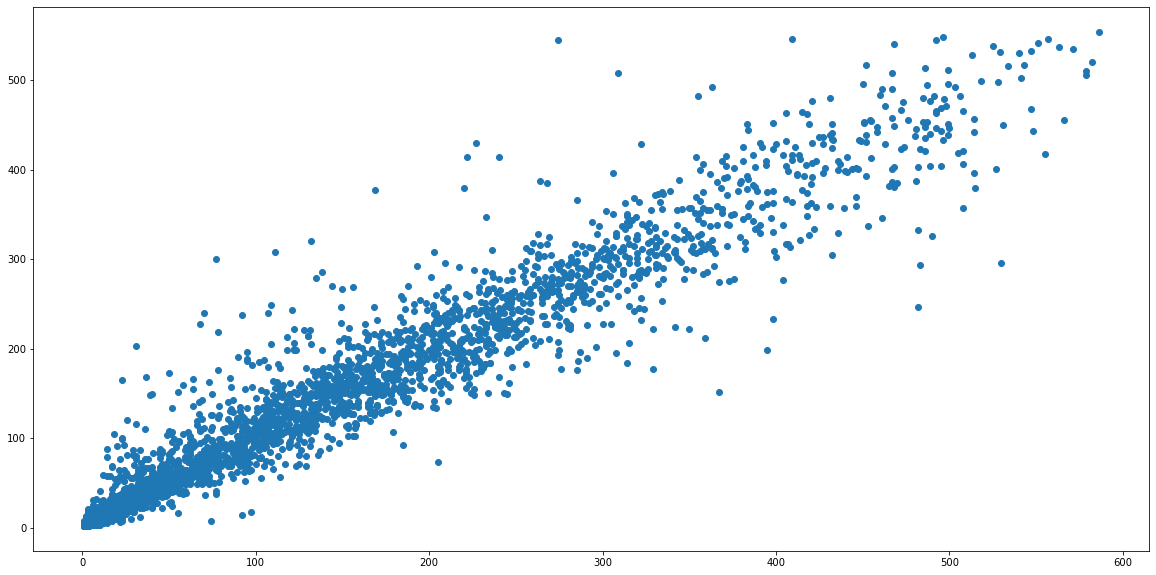

In [49]:
plt.scatter(y_test,rf_prediction)

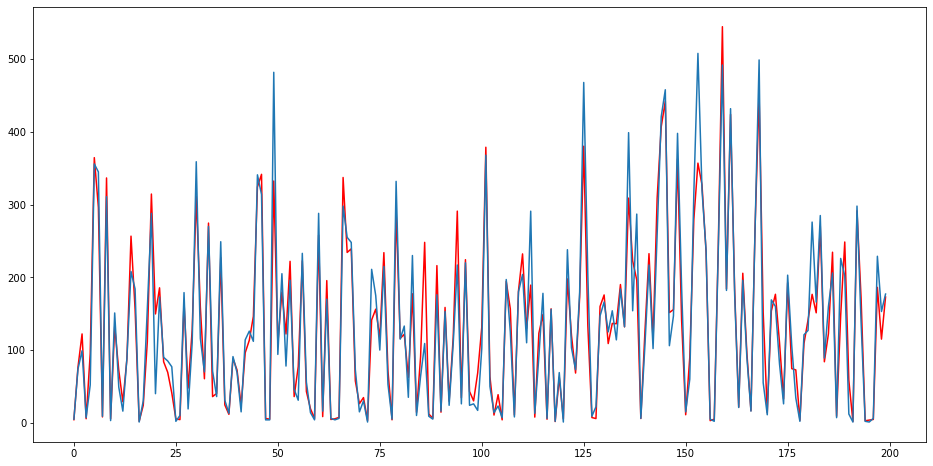

In [50]:
plt.figure(figsize=(16,8))
plt.plot(rf_prediction[0:200],'r')
plt.plot(y_test[0:200].values)

# Make prediction with Decision Tree

In [52]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [53]:
dt_prediction = dt_reg.predict(X_test)

In [54]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dt_prediction)))

RMSE: 50.01961777305143


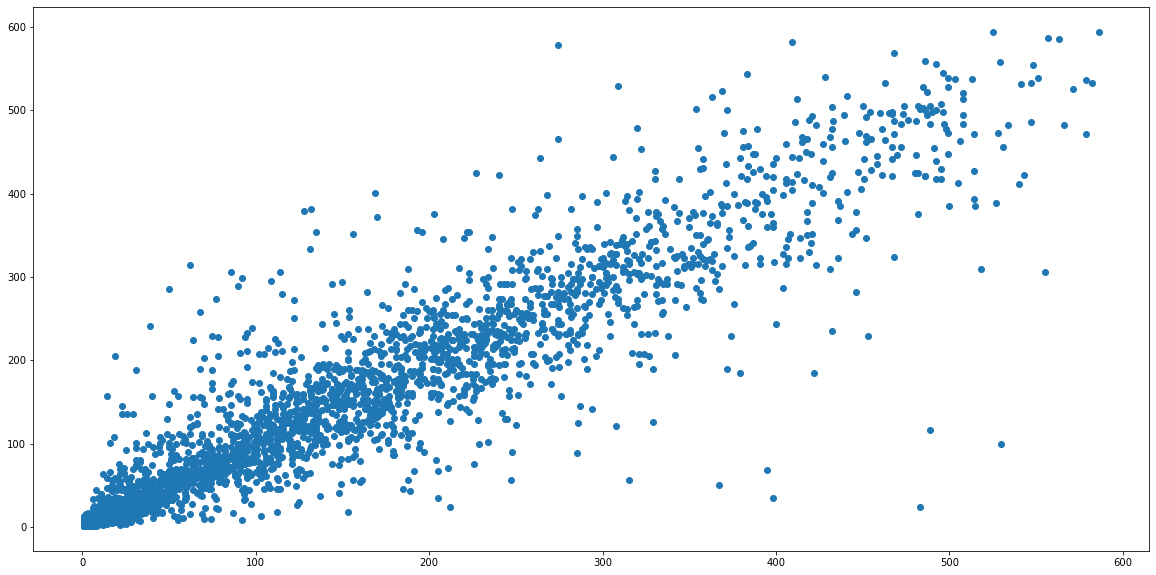

In [55]:
plt.scatter(y_test,dt_prediction)